In [1]:
import os
import gc
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
len_train = 307511

merged_df = pd.read_pickle('./data/merged_df.pkl')
meta_df = pd.read_pickle('./data/meta_df.pkl')
with open("./data/categorical_feats.txt", "rb") as fp: categorical_feats = pickle.load(fp)
with open("./data/non_obj_categoricals.txt", "rb") as fp: non_obj_categoricals = pickle.load(fp)
with open("./data/encoder_dict.txt", "rb") as fp: encoder_dict = pickle.load(fp)

In [22]:
# Extract target before scaling
labels = merged_df.pop('TARGET')
labels = labels[:len_train]

# Reshape (one-hot)
target = np.zeros([len(labels), len(np.unique(labels))])
target[:, 0] = labels == 0
target[:, 1] = labels == 1

In [23]:
# Check nulls
null_counts = merged_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_ratios = null_counts / len(merged_df)

# Drop columns over x% null
null_thresh = .8
null_cols = null_ratios[null_ratios > null_thresh].index
merged_df.drop(null_cols, axis=1, inplace=True)
print('Columns dropped for being over {}% null:'.format(100*null_thresh))
for col in null_cols:
    print(col)
    if col in categorical_feats:
        categorical_feats.pop(col)
    
# merged_df.fillna(merged_df.median(), inplace=True)
merged_df.fillna(0, inplace=True)

Columns dropped for being over 80.0% null:
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_DRAWINGS_POS_CURRENT
CNT_INSTALMENT_MATURE_CUM
MONTHS_BALANCE_B_B


In [24]:
cat_feats_idx = np.array([merged_df.columns.get_loc(x) for x in categorical_feats])
int_feats_idx = [merged_df.columns.get_loc(x) for x in non_obj_categoricals]
cat_feat_lookup = pd.DataFrame({'feature': categorical_feats, 'column_index': cat_feats_idx})
#cat_feat_lookup.head()

In [25]:
cont_feats_idx = np.array(
    [merged_df.columns.get_loc(x) 
     for x in merged_df.columns[~merged_df.columns.isin(categorical_feats)]]
)
cont_feat_lookup = pd.DataFrame(
    {'feature': merged_df.columns[~merged_df.columns.isin(categorical_feats)], 
     'column_index': cont_feats_idx}
)
#cont_feat_lookup.head()

In [26]:
scaler = StandardScaler()
final_col_names = merged_df.columns
merged_df = merged_df.values
merged_df[:, cont_feats_idx] = scaler.fit_transform(merged_df[:, cont_feats_idx])

scaler_2 = MinMaxScaler(feature_range=(0, 1))
merged_df[:, int_feats_idx] = scaler_2.fit_transform(merged_df[:, int_feats_idx])

## 2. Building the graph <a name="graph"></a>

Now the data is in decent shape, build the NN. 

First step, however, is to re-separate the competition train and test sets. I'll then further split the training set down to provide a hold out validation set.

In [27]:
# Re-separate into labelled and unlabelled
train_df = merged_df[:len_train]
predict_df = merged_df[len_train:]
#del merged_df
#gc.collect()

# Create a validation set to check training performance
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, test_size=0.1, random_state=2, stratify=target[:, 0])

In [28]:
# Fixed graph parameters
layer_mult = 1.5
N_HIDDEN_1 = int(128*layer_mult)
N_HIDDEN_2 = int(256*layer_mult)
N_HIDDEN_3 = int(128*layer_mult)
N_HIDDEN_4 = int(64*layer_mult)
N_HIDDEN_5 = int(32*layer_mult)

n_cont_inputs = X_train[:, cont_feats_idx].shape[1]
n_classes = 2

# Learning parameters
LEARNING_RATE = 0.0005
N_EPOCHS = 24
N_ITERATIONS = int(512*1)
BATCH_SIZE = int(256*1)
print('Number of continous features: ', n_cont_inputs)
print('Number of categoricals pre-embedding: ', X_train[:, cat_feats_idx].shape[1])

Number of continous features:  167
Number of categoricals pre-embedding:  67


In [29]:
def embed_and_attach(X, X_cat, cardinality):  
    embedding = tf.Variable(tf.random_uniform([cardinality, cardinality // 2], -1.0, 1.0))
    embedded_x = tf.nn.embedding_lookup(embedding, X_cat) 
    return tf.concat([embedded_x, X], axis=1)

In [30]:
# # Graph
tf.reset_default_graph()

# Define placeholders for the categorical varaibles
cat_placeholders, cat_cardinalities = [], []
for idx in cat_feats_idx:
    exec('X_cat_{} = tf.placeholder(tf.int32, shape=(None, ), name=\'X_cat_{}\')'.format(idx, idx))
    exec('cat_placeholders.append(X_cat_{})'.format(idx))
    cat_cardinalities.append(len(np.unique(np.concatenate([train_df[:, idx], 
                                                           predict_df[:, idx]], axis=0))))
    
# Other placeholders
X_cont = tf.placeholder(tf.float32, shape=(None, n_cont_inputs), name='X_cont')
y = tf.placeholder(tf.int32, shape=(None, n_classes), name='labels')
train_mode = tf.placeholder(tf.bool)

# Add embeddings to input
X = tf.identity(X_cont)
for feat, card in zip(cat_placeholders, cat_cardinalities):
    X = embed_and_attach(X, feat, card)

# Define the network layers. 
# Overfitting is a challenge so add L2 regularisation to weights in 1st layer & 
# a couple of dropout layers
with tf.name_scope('dnn'):
    hidden_layer_1 = tf.layers.dense(inputs=X,
                                     units=N_HIDDEN_1,
                                     name='first_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.4))
    hidden_layer_1 = tf.layers.batch_normalization(hidden_layer_1, training=train_mode)
    hidden_layer_1 = tf.nn.relu(hidden_layer_1)
    
    drop_layer_1 = tf.layers.dropout(inputs=hidden_layer_1, 
                                     rate=0.6, 
                                     name='first_dropout_layer',
                                     training=train_mode)

    hidden_layer_2 = tf.layers.dense(inputs=drop_layer_1,
                                     units=N_HIDDEN_2,
                                     name='second_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.2))
    hidden_layer_2 = tf.layers.batch_normalization(hidden_layer_2, training=train_mode)
    hidden_layer_2 = tf.nn.relu(hidden_layer_2)
                                     
    drop_layer_2 = tf.layers.dropout(inputs=hidden_layer_2, 
                                     rate=0.4, 
                                     name='second_dropout_layer',
                                     training=train_mode)

    hidden_layer_3 = tf.layers.dense(inputs=drop_layer_2,
                                     units=N_HIDDEN_3,
                                     name='third_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    hidden_layer_3 = tf.layers.batch_normalization(hidden_layer_3, training=train_mode)
    hidden_layer_3 = tf.nn.relu(hidden_layer_3)
    
    drop_layer_3 = tf.layers.dropout(inputs=hidden_layer_3, 
                                     rate=0.2, 
                                     name='third_dropout_layer',
                                     training=train_mode)

    hidden_layer_4 = tf.layers.dense(inputs=drop_layer_3,
                                     units=N_HIDDEN_4,
                                     name='fourth_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.05))
    hidden_layer_4 = tf.layers.batch_normalization(hidden_layer_4, training=train_mode)
    hidden_layer_4 = tf.nn.relu(hidden_layer_4)
     
    drop_layer_4 = tf.layers.dropout(inputs=hidden_layer_4, 
                                     rate=0.2, 
                                     name='fourth_dropout_layer',
                                     training=train_mode)
    
    hidden_layer_5 = tf.layers.dense(inputs=drop_layer_4,
                                     units=N_HIDDEN_5,
                                     name='fifth_hidden_layer')
    hidden_layer_5 = tf.layers.batch_normalization(hidden_layer_5, training=train_mode)
    hidden_layer_5 = tf.nn.relu(hidden_layer_5)
    
    logits = tf.layers.dense(inputs=hidden_layer_5,
                             units=n_classes,
                             name='outputs')

# Define the loss function for training as cross entropy
with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    loss = tf.reduce_mean(xent, name='loss')

# Define the optimiser
with tf.name_scope('train'):
    optimiser = tf.train.AdamOptimizer()  # AdagradOptimizer(learning_rate=LEARNING_RATE)
    train_step = optimiser.minimize(loss)

# Output the class probabilities to I can get the AUC
with tf.name_scope('eval'):
    predict = tf.argmax(logits, axis=1, name='class_predictions')
    predict_proba = tf.nn.softmax(logits, name='probability_predictions')

# Initialisation node and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 3. Training the NN <a name="train"></a>

In [31]:
def get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, batch_X, batch_y=None,
                 training=False):
    """ Return a feed dict for the graph including all the categorical features
    to embed """
    
    # Continuous X features and the labels if training run
    feed_dict = {X_cont: batch_X[:, cont_feats_idx]}
    if batch_y is not None:
        feed_dict[y] = batch_y
        
    # Loop through the categorical features to provide values for the placeholders
    for idx, tensor in zip(cat_feats_idx, cat_placeholders):
        feed_dict[tensor] = batch_X[:, idx].reshape(-1, ).astype(int)
        
    # Training mode or not
    feed_dict[train_mode] = training
        
    return feed_dict

In [32]:
train_auc, valid_auc = [], []
n_rounds_not_improved = 0
early_stopping_epochs = 3
with tf.Session() as sess:

    init.run()

    # Begin epoch loop
    print('Training for {} iterations over {} epochs with batchsize {} ...'
          .format(N_ITERATIONS, N_EPOCHS, BATCH_SIZE))
    for epoch in range(N_EPOCHS):
        
        # Iteration loop
        for iteration in range(N_ITERATIONS):

            # Get random selection of data for batch GD. Upsample positive classes to make it
            # balanced in the training batch
            pos_ratio = 0.5
            pos_idx = np.random.choice(np.where(y_train[:, 1] == 1)[0], 
                                       size=int(np.round(BATCH_SIZE*pos_ratio)))
            neg_idx = np.random.choice(np.where(y_train[:, 1] == 0)[0], 
                                       size=int(np.round(BATCH_SIZE*(1-pos_ratio))))
            idx = np.concatenate([pos_idx, neg_idx])
            
            # Run training
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            sess.run([train_step, extra_update_ops], 
                     feed_dict=get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, 
                                             X_train[idx, :], y_train[idx, :], 1))

        # Check on the AUC
        y_pred_train, y_prob_train = sess.run(
            [predict, predict_proba], feed_dict=get_feed_dict(
                cat_feats_idx, cat_placeholders, cont_feats_idx, X_train, y_train, False))
        train_auc.append(roc_auc_score(y_train[:, 1], y_prob_train[:, 1]))
        
        y_pred_val, y_prob_val = sess.run(
            [predict, predict_proba], feed_dict=get_feed_dict(
                cat_feats_idx, cat_placeholders, cont_feats_idx, X_valid, y_valid, False))
        valid_auc.append(roc_auc_score(y_valid[:, 1], y_prob_val[:, 1]))
        
        # Early stopping
        if epoch > 1:
            best_epoch_so_far = np.argmax(valid_auc[:-1])
            if valid_auc[epoch] <= valid_auc[best_epoch_so_far]:
                n_rounds_not_improved += 1
            else:
                n_rounds_not_improved = 0       
            if n_rounds_not_improved > early_stopping_epochs:
                print('Early stopping due to no improvement after {} epochs.'
                      .format(early_stopping_epochs))
                break
        print('Epoch = {}, Train AUC = {:.8f}, Valid AUC = {:.8f}'
              .format(epoch, train_auc[epoch], valid_auc[epoch]))

    # Once trained, make predictions
    print('Training complete.')
    y_prob = sess.run(predict_proba, feed_dict=get_feed_dict(
        cat_feats_idx, cat_placeholders, cont_feats_idx, predict_df, None, False))

Training for 512 iterations over 24 epochs with batchsize 256 ...
Epoch = 0, Train AUC = 0.73741190, Valid AUC = 0.72739728
Epoch = 1, Train AUC = 0.75090032, Valid AUC = 0.73813981
Epoch = 2, Train AUC = 0.75548049, Valid AUC = 0.74153354
Epoch = 3, Train AUC = 0.75752372, Valid AUC = 0.74277677
Epoch = 4, Train AUC = 0.76151039, Valid AUC = 0.74457298
Epoch = 5, Train AUC = 0.76598257, Valid AUC = 0.74698233
Epoch = 6, Train AUC = 0.76860277, Valid AUC = 0.74906553
Epoch = 7, Train AUC = 0.77059277, Valid AUC = 0.75022950
Epoch = 8, Train AUC = 0.77260685, Valid AUC = 0.75218633
Epoch = 9, Train AUC = 0.77510551, Valid AUC = 0.75244313
Epoch = 10, Train AUC = 0.77756247, Valid AUC = 0.75227344
Epoch = 11, Train AUC = 0.77997701, Valid AUC = 0.75420442
Epoch = 12, Train AUC = 0.78151835, Valid AUC = 0.75600863
Epoch = 13, Train AUC = 0.78431009, Valid AUC = 0.75617289
Epoch = 14, Train AUC = 0.78570478, Valid AUC = 0.75600056
Epoch = 15, Train AUC = 0.78756680, Valid AUC = 0.75715576


## 4. Analysis and Submission <a name="submit"></a>

Lets have a look at some summarising plots, then submit the results. 

Training curves & the ROC curve:

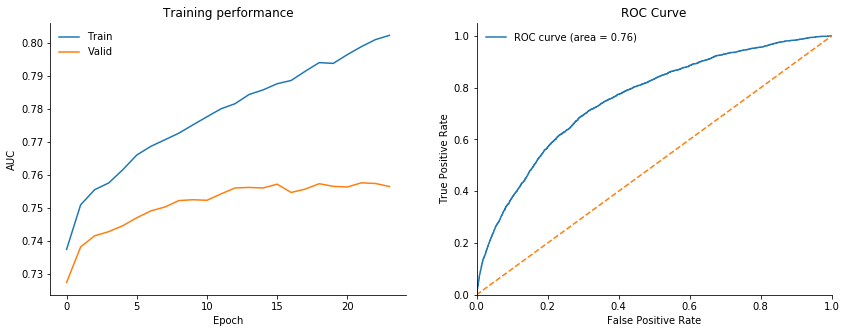

In [33]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])
ax.plot(np.arange(len(train_auc)), train_auc, label='Train')
ax.plot(np.arange(len(valid_auc)), valid_auc, label='Valid')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_title('Training performance')

fpr, tpr, _ = roc_curve(y_valid[:, 1], y_prob_val[:, 1])
ax1.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(valid_auc[epoch]))
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

for a in [ax, ax1]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.legend(frameon=False)

plt.show()

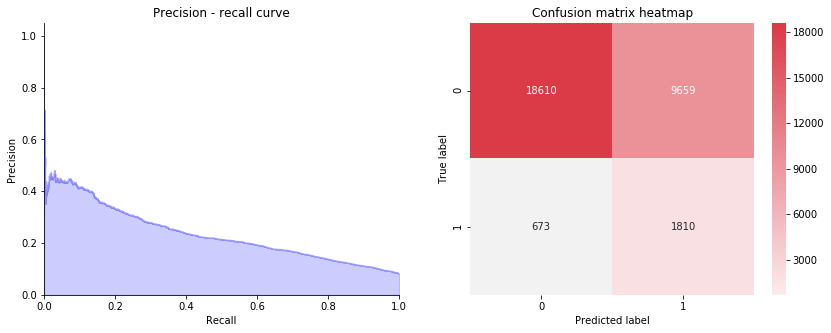

In [34]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])

# Precision recall curve
precision, recall, _ = precision_recall_curve(y_valid[:, 1], y_prob_val[:, 1])
ax.step(recall, precision, color='b', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Precision - recall curve')

# Confusion matrix
cnf_matrix = confusion_matrix(y_valid[:, 1], np.argmax(y_prob_val, axis=1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax1, cmap=cmap, center=0)
ax1.set_title('Confusion matrix heatmap')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

plt.show()

In [20]:
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_prob[:, 1]})
out_df.to_csv('nn_submission.csv', index=False)

NameError: name 'meta_df' is not defined